In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
import os

import flax
from flax import jax_utils
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import torch
import tensorflow as tf
import tqdm

import init2winit
import fastmri

import i2w

from fastmri.models import unet as t_unet
from fastmri.pl_modules import data_module
from fastmri.pl_modules import unet_module
from fastmri.data.transforms import UnetDataTransform
from fastmri.data.subsample import create_mask_for_mask_type

from init2winit.model_lib import unet as f_unet
from init2winit.dataset_lib import fastmri_dataset
from init2winit.dataset_lib import data_utils
from init2winit.optimizer_lib import optimizers
from init2winit.optimizer_lib import transform

jax.devices()

Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0),
 GpuDevice(id=4, process_index=0),
 GpuDevice(id=5, process_index=0),
 GpuDevice(id=6, process_index=0),
 GpuDevice(id=7, process_index=0)]

# Manual train step

In [2]:
data_path = pathlib.Path('../../')
challenge = 'singlecoil'
center_fractions = [0.08]
accelerations = [4]
mask_type = 'random'
test_split = 'test'
batch_size = 8

lr = 0.001
lr_step_size = 40
lr_gamma = 0.1
weight_decay = 0.0

In [3]:
def create_batch(t_batch, batch_idx):
    batch_size = len(t_batch.slice_num)
    inputs = [i2w.get_slice(os.path.join('../../singlecoil_train', t_batch.fname[i]), t_batch.slice_num[i]) for i in range(batch_size)]
    processed = [fastmri_dataset._process_example(*input, tf.cast(jax.random.PRNGKey(batch_idx), tf.int64)) for input in inputs]
    batched = [{key: tf.expand_dims(value, 0) for key, value in f.items()} for f in processed]

    f_batch = {}
    for key in batched[0].keys():
        f_batch[key] = tf.concat([batched[i][key] for i in range(batch_size)], axis=0).numpy()
        
    return f_batch

In [4]:
mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

train_transform = UnetDataTransform(challenge, mask_func=mask, use_seed=False)
val_transform = UnetDataTransform(challenge, mask_func=mask)
test_transform = UnetDataTransform(challenge)

dm8 = data_module.FastMriDataModule(
    data_path=data_path,
    challenge=challenge,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    test_split=test_split,
    batch_size=batch_size,
    num_workers=4,
)

dl8 = iter(dm8.train_dataloader())

## `fastmri`

In [5]:
t_model = unet_module.UnetModule()
t_opt, t_lr = t_model.configure_optimizers()
t_opt, t_lr = t_opt[0], t_lr[0]

## `init2winit`

In [6]:
f_model = f_unet.UNetModel(f_unet.DEFAULT_HPARAMS, {}, 'mean_absolute_error', 'image_reconstruction_metrics')
f_params = i2w.convert_params(t_model.unet, f_model.flax_module)

f_opt_init, f_opt_update = f_opt = optax.chain(transform.precondition_by_rms(decay=0.99), optax.scale_by_schedule(optax.piecewise_constant_schedule(init_value=-lr, boundaries_and_scales={lr_step_size: lr_gamma})))
f_opt_state = f_opt_init(f_params)

Abs sum diff: 0.1003558


In [7]:
def loss(params, image, y):
    return jnp.abs(f_model.flax_module.apply(params, image) - y).mean()

In [8]:
count = 0

# NOTE: no t_lr.step() because we're operating on steps now, not epochs.

data = []
for i, t_batch in enumerate(dl8):
    if count == 500:
        break
    t_opt.zero_grad()
    
    f_batch = create_batch(t_batch, i)
    
    t_fwd = t_model(t_batch.image).detach().numpy()
    f_fwd = np.array(f_model.flax_module.apply(f_params, f_batch['inputs']))
    
    delta = np.mean(np.abs(t_fwd - f_fwd))
    print(delta)
    
    t_loss = t_model.training_step(t_batch, i)
    t_loss.backward()
    t_opt.step()
    
    f_loss, grad = jax.value_and_grad(loss)(f_params, f_batch['inputs'].squeeze(), f_batch['targets'].squeeze())
    updates, f_opt_state = f_opt_update(grad, f_opt_state, f_params)
    f_params = optax.apply_updates(f_params, updates)
    
    print(i, t_loss.detach().numpy(), f_loss)
    data.append((delta, t_loss.detach().numpy(), f_loss))
    count += 1

0.2735228


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/lightning.py:373: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  "You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet."
2022-05-09 21:08:42.848305: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[2,2,64,32]{1,0,2,3}, u8[0]{0}) custom-call(f32[8,320,320,32]{2,1,0,3}, f32[8,319,319,64]{2,1,0,3}), window={size=319x319 rhs_reversal=1x1}, dim_labels=f01b_i01o->01fb, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-05-09 21:08:49.027726: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algo

0 0.88550055 0.8590181
0.069824055
1 0.604906 0.6027177
0.12847953
2 0.5439199 0.52456087
0.1733511
3 0.81227326 0.8508328
0.22289202
4 0.8435862 0.8682616
0.049354088
5 0.3231284 0.32294562
0.06990834
6 0.33156568 0.34975064
0.11202004
7 0.42769784 0.42392027
0.11408628
8 0.39287516 0.3591652
0.11041278
9 0.26563942 0.27584264
0.09992959
10 0.22882502 0.20508906
0.12815282
11 0.20761171 0.24104835
0.10118631
12 0.18864238 0.22122993
0.087788716
13 0.21557148 0.20323539
0.1093882
14 0.176335 0.20289761
0.061015
15 0.22488327 0.21786323
0.072857335
16 0.26221368 0.28009123
0.08109618
17 0.27258527 0.27005658
0.10575645
18 0.25075024 0.25132412
0.043006606
19 0.22456358 0.2281546
0.04315001
20 0.16314915 0.15994203
0.07241557
21 0.2239467 0.22919475
0.08882494
22 0.2062094 0.2183449
0.09455101
23 0.38342753 0.37687773
0.046206485
24 0.2198203 0.21474205
0.07469027
25 0.22181505 0.21958053
0.09627254
26 0.27037197 0.27017304
0.08973615
27 0.3291379 0.33119652
0.07112274
28 0.42622375 0.42

0.17510857
229 0.355251 0.36584058
0.2328405
230 0.5119548 0.5459949
0.24492447
231 0.49433458 0.552811
0.097982235
232 0.15806726 0.12785147
0.13149315
233 0.17470632 0.18819325
0.1549015
234 0.19825663 0.21194063
0.16872004
235 0.26887795 0.22174849
0.100748494
236 0.29072475 0.29055476
0.16463806
237 0.28556815 0.30060548
0.16147727
238 0.3365366 0.35612112
0.21482767
239 0.5025217 0.519426
0.07925598
240 0.15380609 0.16276856
0.107349806
241 0.18823928 0.19508572
0.15573181
242 0.2279054 0.23924755
0.117967814
243 0.20008078 0.22044863
0.15747371
244 0.47974014 0.50546193
0.1809608
245 0.44731823 0.46448645
0.24137549
246 0.5109589 0.55643857
0.2859827
247 0.6155697 0.65688366
0.3437108
248 0.77585226 0.827894
0.23031157
249 0.4469771 0.47068003
0.17632417
250 0.36252537 0.3714799
0.21594313
251 0.46954563 0.5051653
0.23059958
252 0.5250042 0.5560813
0.13109142
253 0.24417418 0.2550063
0.11411987
254 0.1869196 0.18803822
0.17632416
255 0.34124726 0.3510099
0.20536226
256 0.40018243

0.22230859
456 0.43351537 0.436277
0.09597564
457 0.14791693 0.15046816
0.118799984
458 0.1672078 0.18782184
0.14451489
459 0.19118929 0.20374893
0.09494149
460 0.14659208 0.15854304
0.17817281
461 0.33350676 0.3704156
0.3055353
462 1.0130966 1.0589356
0.32596835
463 0.58755046 0.640996
0.30240545
464 0.5933197 0.62479085
0.24280356
465 0.43007147 0.42958838
0.14319696
466 0.25383896 0.2717757
0.15434846
467 0.2778545 0.27985182
0.19666472
468 0.33373332 0.33142075
0.1788591
469 0.31302357 0.3310351
0.14766654
470 0.20733474 0.2134598
0.08936002
471 0.1723178 0.18238984
0.08593849
472 0.14850114 0.15728407
0.11717211
473 0.19028637 0.19325933
0.119032815
474 0.1741506 0.19741611
0.2574222
475 0.5557351 0.60998386
0.1431998
476 0.2658053 0.26515475
0.17566703
477 0.23708965 0.25547388
0.16017962
478 0.2467479 0.25907147
0.22419494
479 0.5459185 0.54498625
0.13299151
480 0.21300107 0.21547386
0.15967532
481 0.2581692 0.24876574
0.14036998
482 0.24608444 0.2670614
0.20334204
483 0.4159013

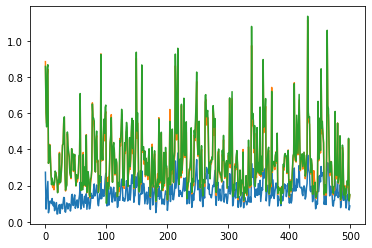

In [9]:
plt.plot(np.array(data))

In [ ]:
plt.plot(np.array(data))